In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Big_Data/data_clean.csv')
df

,comment,label
0,microphone bad cannot use zoom meet youre not ...,negative
1,buy early january great theyre comfortable goo...,positive
2,dis like ear bud no base soundu get pay,negative
3,weeks one ear bud already break hear leave one,negative
4,cheaply make try replace silicone cap earbud c...,negative
...,...,...
18649,best market dj musician regular old person lov...,negative
18650,great comfortable light wear hours game watch ...,positive
18651,look close back use along side sennheiser hd s...,positive
18652,perfect studio use need lot power drive things...,positive


Naive Bayes

In [5]:
l = []
for i in df['label']:
  if i == 'negative':
    l.append(0)
  else:
    l.append(1)

In [6]:
l = np.array(l)
l

array([0, 1, 0, ..., 1, 1, 1])

In [7]:
df['comment']=df['comment'].apply(lambda x: str(x))

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df['comment'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [9]:
from sklearn.model_selection import train_test_split
X=text_counts
y= l
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=30)

In [10]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
CNB = ComplementNB()
CNB.fit(X_train, y_train)

from sklearn import metrics
predicted = CNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('ComplementNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

ComplementNB model accuracy is 76.71%
------------------------------------------------
Confusion Matrix:
     0     1
0  605   387
1  482  2257
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.61      0.58       992
           1       0.85      0.82      0.84      2739

    accuracy                           0.77      3731
   macro avg       0.71      0.72      0.71      3731
weighted avg       0.77      0.77      0.77      3731



BiLSTM

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Bidirectional, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re

In [30]:
Y = l
X = df["comment"]

In [31]:
vocab_size = 200000
output_dim = 32
max_length = 1800

tokenizer = Tokenizer(num_words= vocab_size, oov_token= "<OOV>")
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=max_length, truncating= "post", padding= "post")

In [32]:
from sklearn.preprocessing import OneHotEncoder

In [33]:
One_hot = LabelEncoder()
Y_target = One_hot.fit_transform(Y)
Y_target.shape

(18654,)

In [34]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((X_padded, Y_target))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(512)
dataset = dataset.prefetch(8) # helps bottlenecks

In [35]:
train = dataset.take(int(len(dataset)*.6))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.2))

In [36]:
model = Sequential([
    Embedding(input_dim= vocab_size, output_dim= output_dim, input_length= max_length),
    Bidirectional(LSTM(output_dim, activation='tanh')),
    Dense(128, activation= "relu"),
    Dense(64, activation= "relu"),
    Dense(32, activation= "relu"),
    Dense(1, activation= "sigmoid")
])

model.compile(loss= BinaryCrossentropy(),
              optimizer= Adam(learning_rate= 0.001),
              metrics= ["accuracy"])

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1800, 32)          6400000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                      

In [38]:
def plot_training_history(history):
    # Lấy các thông tin về mất mát và độ chính xác từ lịch sử huấn luyện
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Vẽ biểu đồ mất mát
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Vẽ biểu đồ độ chính xác
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


Epoch 1/50
22/22 [==============================] - 16s 377ms/step - loss: 0.6382 - accuracy: 0.7120 - val_loss: 0.5951 - val_accuracy: 0.7190
Epoch 2/50
22/22 [==============================] - 9s 417ms/step - loss: 0.5667 - accuracy: 0.7342 - val_loss: 0.5544 - val_accuracy: 0.7257
Epoch 3/50
22/22 [==============================] - 7s 303ms/step - loss: 0.4823 - accuracy: 0.7374 - val_loss: 0.4425 - val_accuracy: 0.7623
Epoch 4/50
22/22 [==============================] - 8s 354ms/step - loss: 0.4868 - accuracy: 0.8085 - val_loss: 0.3920 - val_accuracy: 0.8064
Epoch 5/50
22/22 [==============================] - 6s 280ms/step - loss: 0.3601 - accuracy: 0.8349 - val_loss: 0.3193 - val_accuracy: 0.8630
Epoch 6/50
22/22 [==============================] - 6s 256ms/step - loss: 0.3079 - accuracy: 0.8688 - val_loss: 0.2895 - val_accuracy: 0.8783
Epoch 7/50
22/22 [==============================] - 7s 303ms/step - loss: 0.2807 - accuracy: 0.8875 - val_loss: 0.2346 - val_accuracy: 0.9082
Epoch

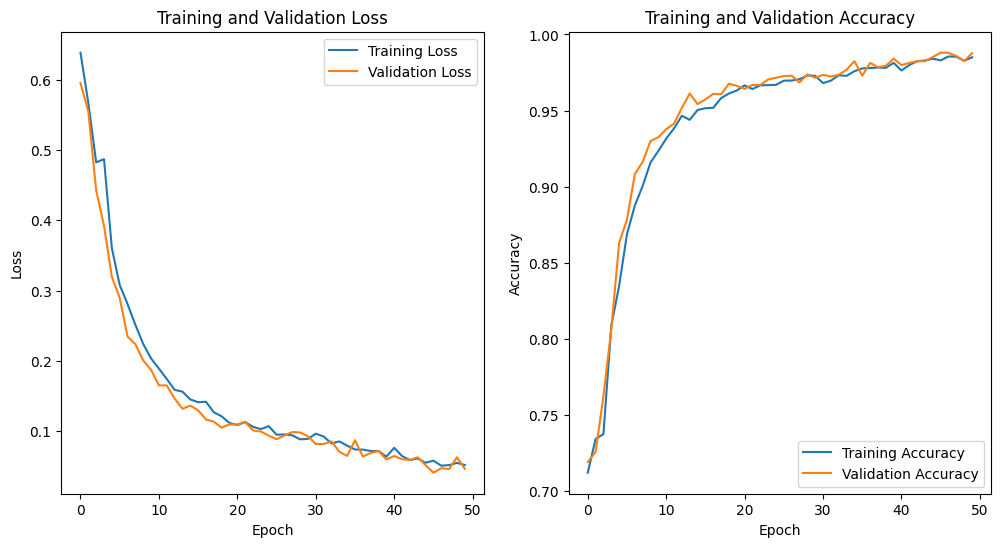

In [39]:
import time
start = time.time()
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train, epochs= 50, validation_data= val, verbose= 1)

end = time.time()
execution_time = end - start
print("==============================")
print("execution_time: ", execution_time)
print("==============================")
plot_training_history(history)